Reference: Molecular Similarity-Based Domain Applicability Metric Efficiently Identifies Out-of-Domain Compounds

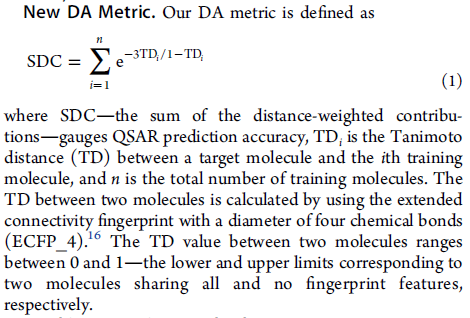

In [9]:
from IPython.display import Image
Image("da_metric.PNG")

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import oddt
from oddt.fingerprints import ECFP
import numpy as np

In [11]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
# mols = oddt.toolkit.readfile('smi', 'data/test_smiles.smi')

In [14]:
smiles = []

with open("data/test_smiles.smi") as f:
    for line in f.read().splitlines():
        if line:
            smiles.append(line)

# Convert into Canonical SMILES
smiles = [Chem.CanonSmiles(s) for s in smiles]

train_smiles = smiles[:-50]
test_smiles = smiles[-50:]

In [15]:
class AD:
    def __init__(self, train_data):
        if not isinstance(train_data, list) or not train_data or len(train_data) < 10:
            raise Exception("Training data should be a list of at least 10 SMILES")
        
        # Canonicalize the SMILES
        self.train_data = [Chem.CanonSmiles(sm) for sm in smiles if len(sm) > 0]
        self.fingerprints = []
    
    def fit(self):
        # Find the fingerprints
        for sm in self.train_data:
            mol = Chem.MolFromSmiles(sm)
            if not mol:
                continue
            self.fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2))
            
        if len(self.fingerprints) < 5:
            raise Exception(f"Not enough fingerprints can be generated from the training data (len={len(self.fingerprints)})")
    
    def get_score(self, smiles):
        if not self.fingerprints:
            raise Exception("Please run fit() first.")
            
        smiles = Chem.CanonSmiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        
        if not mol:
            raise Exception("Invalid SMILES.")
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2)
        scores = []
        
        for train_fp in self.fingerprints:
            scores.append(DataStructs.TanimotoSimilarity(train_fp, fp))
        
        scores = np.array(scores)
        return np.sum(np.exp(-1 * (3 * scores) / (1 - scores)))

## Example

In [16]:
from glob import glob
import pandas as pd

In [17]:
smiles_file = '../redial-2020/redial-2020-notebook-work/combined_data/ACE2/ACE2-balanced_randomsplit7_70_15_15_'
train_smiles = pd.read_csv(smiles_file + 'tr.csv', usecols=[4, 161])
test_smiles = pd.read_csv(smiles_file + 'te.csv', usecols = [4, 161])
valid_smiles = pd.read_csv(smiles_file + 'va.csv', usecols = [4, 161])

In [18]:
result_df = pd.read_csv("../redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/test/ACE2_te.csv")
result_df.head()

,MOL.ID,DC.ID,SMILES_stand,InChI,SMILES,DC.NAME,NCATS.SYNONYMS,NCGC.ID,WARNING,3CL.SIGNIFICANCE,...,rdkDescriptors_pred_label,rdkDescriptors_pred_prob,pharmacophore_pred_label,pharmacophore_pred_prob,volsurf_pred_label,volsurf_pred_prob,Consensus_label,Consensus_prob_label,Consensus_volsurf_label,Consensus_volsurf_prob_label
0,MOL1802,2816.0,C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...,InChI=1S/C41H42N4O8/c1-9-23-20(2)29-17-34-27-1...,C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...,verteporfin,Verteporfin,"NCGC00346712-05, NCGC00346712-01",NaN,INACTIVE,...,1.0,0.884385,1.0,0.512,1.0,0.867915,1.0,1.0,1.0,1.0
1,MOL2451,4899.0,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2cc...,InChI=1S/C49H54F2N8O6/c1-24(2)39(56-46(62)64-5...,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2cc...,ledipasvir,Ledipasvir (GS 5885)|Ledipasvir (D-tartrate),"NCGC00386420-01, NCGC00378990-07",NaN,INACTIVE,...,1.0,0.902587,1.0,0.734,1.0,0.831067,1.0,1.0,1.0,1.0
2,MOL10067,NaN,O=C(O)[C@@H](S)[C@H](S)C(=O)O,"InChI=1S/C4H6O4S2/c5-3(6)1(9)2(10)4(7)8/h1-2,9...",O=C(O)[C@@H](S)[C@H](S)C(=O)O,NaN,"(2R,3R)-2,3-Dimercaptosuccinic acid",NaN,NaN,INACTIVE,...,0.0,0.016729,0.0,0.468,1.0,0.546462,0.0,0.0,0.0,0.0
3,MOL2489,5039.0,O=C(OC[C@H]1O[C@@H](OC(=O)c2cc(O)c(O)c(OC(=O)c...,InChI=1S/C76H52O46/c77-32-1-22(2-33(78)53(32)9...,O=C(OC[C@H]1O[C@@H](OC(=O)c2cc(O)c(O)c(OC(=O)c...,tannic acid,Tannic acid,NaN,Has more than 100 non-H atoms,HIGH,...,1.0,0.724872,1.0,0.742,1.0,0.996307,1.0,1.0,1.0,1.0
4,MOL2510,5155.0,CC[C@@H]1[C@@H]2C[C@H](O)CC[C@]2(C)[C@H]2CC[C@...,InChI=1S/C26H44O4/c1-5-17-21-14-16(27)10-12-26...,CC[C@@H]1[C@@H]2C[C@H](O)CC[C@]2(C)[C@H]2CC[C@...,obeticholic acid,INT-747 (Obeticholic acid),NaN,NaN,INACTIVE,...,0.0,0.010127,0.0,0.170,0.0,0.305642,0.0,0.0,0.0,0.0


In [19]:
tp_mask = result_df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 1, axis = 1)
tn_mask = result_df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 0, axis = 1)
fp_mask = result_df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 1, axis = 1)
fn_mask = result_df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 0, axis = 1)

In [20]:
confusion_matrix(result_df.Label, result_df.fingerprint_pred_label)

array([[12, 12],
       [ 6, 19]])

In [21]:
test_smiles = test_smiles[test_smiles.SMILES.isin(result_df.SMILES)]

In [22]:
train_smiles_actives = train_smiles.Label.apply(lambda x: True if x == 1 else False)
test_smiles_actives = test_smiles.Label.apply(lambda x: True if x == 1 else False)
valid_smiles_actives = valid_smiles.Label.apply(lambda x: True if x == 1 else False)

In [23]:
train_smiles.head()

,SMILES,Label
0,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21,1
1,CC(C)CN(C[C@@H](OP(=O)([O-])[O-])[C@H](Cc1cccc...,1
2,COc1ccc2c(c1)[nH]c1c(C)nccc12,1
3,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2c3ccccc3Sc3c...,0
4,O=c1ccc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)...,1


In [24]:
ad = AD(train_data=train_smiles.SMILES.to_list())
ad.fit()

In [25]:
sdc_scores_test = np.array(test_smiles.SMILES.apply(lambda x: ad.get_score(x)))
sdc_scores_train = np.array(train_smiles.SMILES.apply(lambda x: ad.get_score(x)))
sdc_scores_valid = np.array(valid_smiles.SMILES.apply(lambda x: ad.get_score(x)))

In [26]:
train_actives = sdc_scores_train[train_smiles_actives]
train_nactives = sdc_scores_train[~train_smiles_actives]
test_actives = sdc_scores_test[test_smiles_actives]
test_nactives = sdc_scores_test[~test_smiles_actives]
valid_actives = sdc_scores_valid[valid_smiles_actives]
valid_nactives = sdc_scores_valid[~valid_smiles_actives]

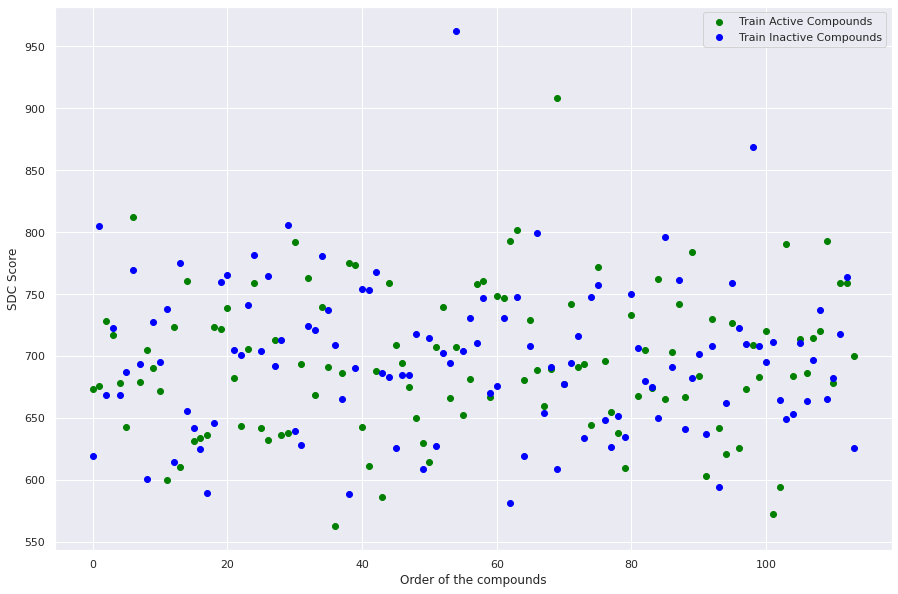

In [27]:
plt.figure(figsize=(15, 10))
plt.scatter(range(len(train_actives)), train_actives, color='green', label = "Train Active Compounds")
plt.scatter(range(len(train_nactives)), train_nactives, color='blue', label = "Train Inactive Compounds")
plt.xlabel("Order of the compounds")
plt.ylabel("SDC Score")
plt.legend()
plt.show()

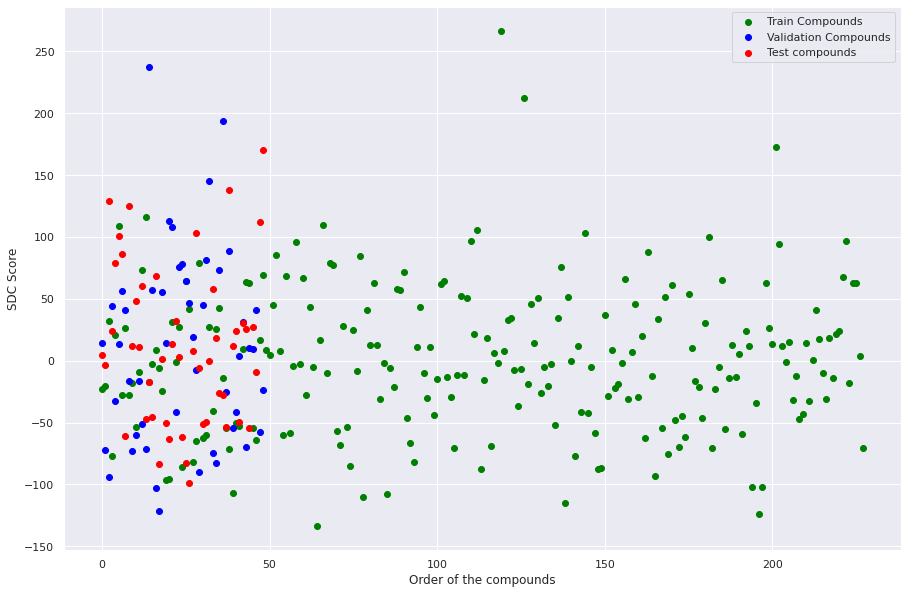

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(range(len(sdc_scores_train)), sdc_scores_train-np.mean(sdc_scores_train), color='green', label = "Train Compounds")
plt.scatter(range(len(sdc_scores_valid)), sdc_scores_valid-np.mean(sdc_scores_train), color='blue', label = "Validation Compounds")
plt.scatter(range(len(sdc_scores_test)), sdc_scores_test-np.mean(sdc_scores_train), color='red', label = "Test compounds")
plt.xlabel("Order of the compounds")
plt.ylabel("SDC Score")
plt.legend()
plt.show()

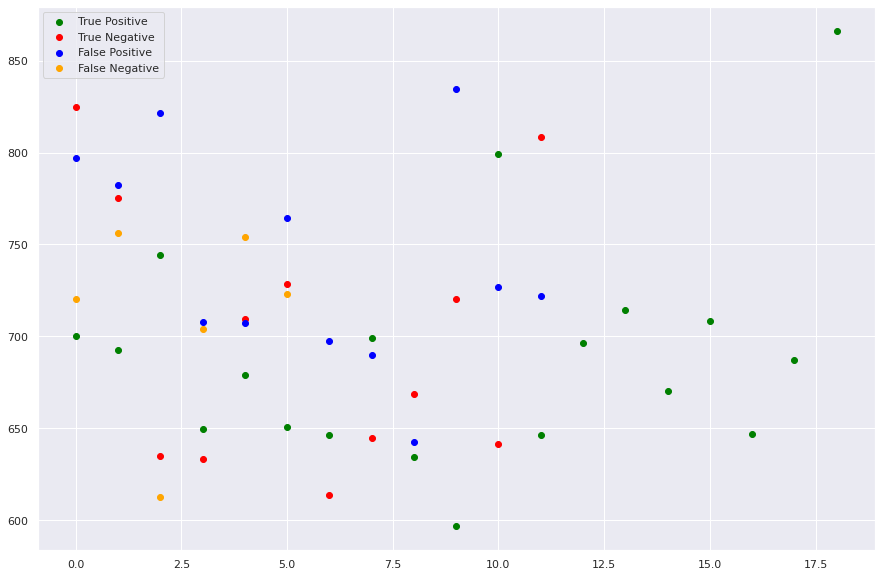

In [29]:
plt.figure(figsize=(15, 10))
# plt.scatter(range(len(sdc_scores_test)), sdc_scores_test, color = 'black', label = "Test Compounds")
plt.scatter(range(len(sdc_scores_test[tp_mask])), sdc_scores_test[tp_mask], color = 'green', label = "True Positive")
plt.scatter(range(len(sdc_scores_test[tn_mask])), sdc_scores_test[tn_mask], color = 'red', label = "True Negative")
plt.scatter(range(len(sdc_scores_test[fp_mask])), sdc_scores_test[fp_mask], color = 'blue', label = "False Positive")
plt.scatter(range(len(sdc_scores_test[fn_mask])), sdc_scores_test[fn_mask], color = 'orange', label = "False Negative")
plt.legend()
plt.show()

In [30]:
result_df.head()

,MOL.ID,DC.ID,SMILES_stand,InChI,SMILES,DC.NAME,NCATS.SYNONYMS,NCGC.ID,WARNING,3CL.SIGNIFICANCE,...,rdkDescriptors_pred_label,rdkDescriptors_pred_prob,pharmacophore_pred_label,pharmacophore_pred_prob,volsurf_pred_label,volsurf_pred_prob,Consensus_label,Consensus_prob_label,Consensus_volsurf_label,Consensus_volsurf_prob_label
0,MOL1802,2816.0,C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...,InChI=1S/C41H42N4O8/c1-9-23-20(2)29-17-34-27-1...,C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...,verteporfin,Verteporfin,"NCGC00346712-05, NCGC00346712-01",NaN,INACTIVE,...,1.0,0.884385,1.0,0.512,1.0,0.867915,1.0,1.0,1.0,1.0
1,MOL2451,4899.0,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2cc...,InChI=1S/C49H54F2N8O6/c1-24(2)39(56-46(62)64-5...,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2cc...,ledipasvir,Ledipasvir (GS 5885)|Ledipasvir (D-tartrate),"NCGC00386420-01, NCGC00378990-07",NaN,INACTIVE,...,1.0,0.902587,1.0,0.734,1.0,0.831067,1.0,1.0,1.0,1.0
2,MOL10067,NaN,O=C(O)[C@@H](S)[C@H](S)C(=O)O,"InChI=1S/C4H6O4S2/c5-3(6)1(9)2(10)4(7)8/h1-2,9...",O=C(O)[C@@H](S)[C@H](S)C(=O)O,NaN,"(2R,3R)-2,3-Dimercaptosuccinic acid",NaN,NaN,INACTIVE,...,0.0,0.016729,0.0,0.468,1.0,0.546462,0.0,0.0,0.0,0.0
3,MOL2489,5039.0,O=C(OC[C@H]1O[C@@H](OC(=O)c2cc(O)c(O)c(OC(=O)c...,InChI=1S/C76H52O46/c77-32-1-22(2-33(78)53(32)9...,O=C(OC[C@H]1O[C@@H](OC(=O)c2cc(O)c(O)c(OC(=O)c...,tannic acid,Tannic acid,NaN,Has more than 100 non-H atoms,HIGH,...,1.0,0.724872,1.0,0.742,1.0,0.996307,1.0,1.0,1.0,1.0
4,MOL2510,5155.0,CC[C@@H]1[C@@H]2C[C@H](O)CC[C@]2(C)[C@H]2CC[C@...,InChI=1S/C26H44O4/c1-5-17-21-14-16(27)10-12-26...,CC[C@@H]1[C@@H]2C[C@H](O)CC[C@]2(C)[C@H]2CC[C@...,obeticholic acid,INT-747 (Obeticholic acid),NaN,NaN,INACTIVE,...,0.0,0.010127,0.0,0.170,0.0,0.305642,0.0,0.0,0.0,0.0


In [31]:
result_df['sdc'] = result_df.SMILES.apply(lambda x: ad.get_score(x))

In [34]:
result_df['preds'] = ''
result_df['preds'][fn_mask] = 'fn'
result_df['preds'][fp_mask] = 'fp'
result_df['preds'][tn_mask] = 'tn'
result_df['preds'][tp_mask] = 'tp'

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

<AxesSubplot:title={'center':'sdc'}, xlabel='preds'>

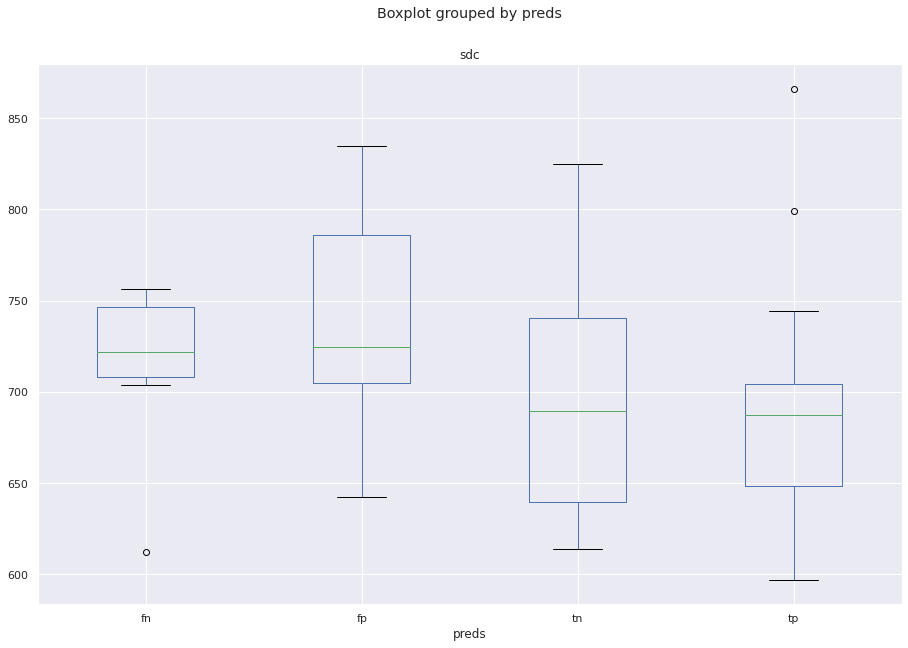

In [36]:
result_df.boxplot(by = 'preds', column='sdc', figsize=(15, 10))

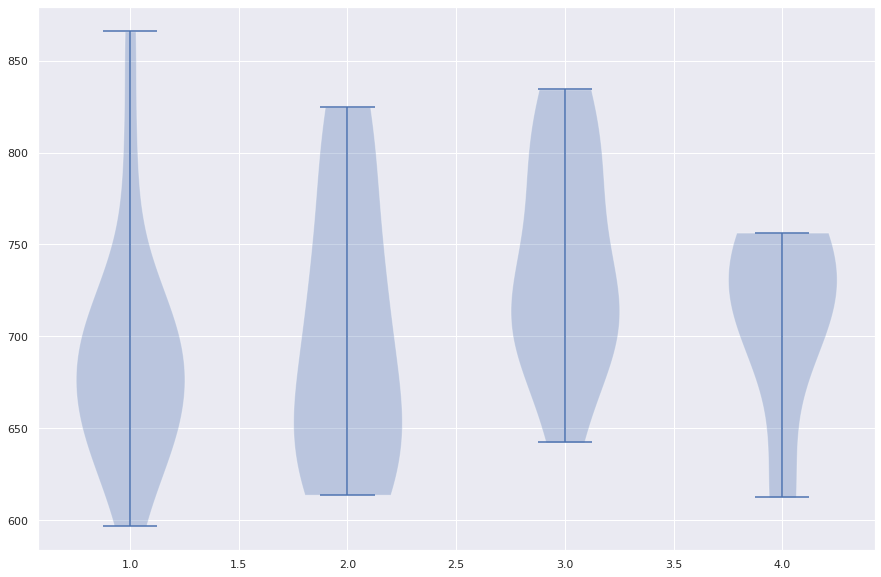

In [60]:
fig, axs = plt.subplots(figsize = (15, 10))
axs.violinplot(dataset = [result_df[result_df.preds == 'tp']['sdc'].values,
                         result_df[result_df.preds == 'tn']['sdc'].values,
                         result_df[result_df.preds == 'fp']['sdc'].values,
                         result_df[result_df.preds == 'fn']['sdc'].values])

plt.show()

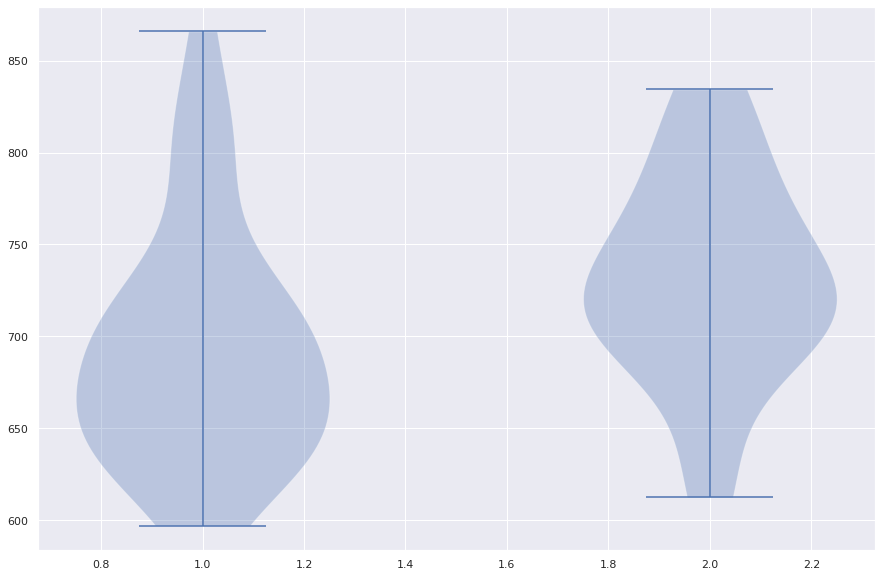

In [70]:
fig, axs = plt.subplots(figsize = (15, 10))
axs.violinplot(dataset = [result_df[(result_df.preds == 'tp') | (result_df.preds == 'tn')]['sdc'].values,
                         result_df[(result_df.preds == 'fp') | (result_df.preds == 'fn')]['sdc'].values])

plt.show()

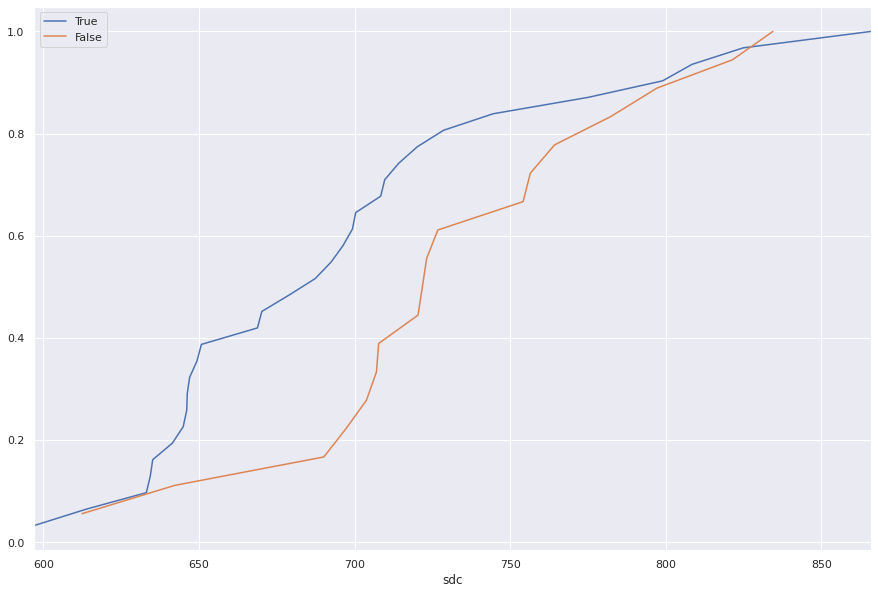

In [78]:
# Get the frequency, PDF and CDF for each value in the series (Correct predictions)

s = result_df[tp_mask | tn_mask]['sdc']
df = pd.DataFrame(s)
stats_tdf = df.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

# PDF
stats_tdf['pdf'] = stats_tdf['frequency'] / sum(stats_tdf['frequency'])

# CDF
stats_tdf['cdf'] = stats_tdf['pdf'].cumsum()
stats_tdf = stats_tdf.reset_index()

# Get the frequency, PDF and CDF for each value in the series (Wrong predictions)

s = result_df[fp_mask | fn_mask]['sdc']
df = pd.DataFrame(s)
stats_fdf = df.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

# PDF
stats_fdf['pdf'] = stats_fdf['frequency'] / sum(stats_fdf['frequency'])

# CDF
stats_fdf['cdf'] = stats_fdf['pdf'].cumsum()
stats_fdf = stats_fdf.reset_index()

fig, axs = plt.subplots(figsize = (15, 10))
stats_tdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['True'], ax = axs)
stats_fdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['False'], ax = axs)
plt.legend()
plt.show()